# Modelo recurrente

## Librerías

In [57]:
import IPython
import IPython.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import tensorflow as tf
import scipy as sp
from statsmodels.graphics.gofplots import qqplot
from itertools import cycle, islice
import random

## Dataframe general

In [58]:
# Funcion que devuelve datos en un intervalo de tiempo dado
def filter_by_dates(begin,end,data):
    return data[data[data['dates']==begin].index[0]:data[data['dates']==end].index[0]]

In [59]:
df = pd.read_csv("data.csv")
#df = filter_by_dates('2005-01-31','2019-12-31',df)

## Agrupamiento de datos

In [60]:
# Codigo importado del notebook de analisis

interest_groups = df.columns[-10:-2]
continents = ["Africa", "Americas", "Asia", "Europe", "Oceania"]
regions = [name for name in df.columns[250:272] if name not in continents]
interest_groups_df = df[interest_groups]
continents_df = df[continents]
regions_df = df[regions]
world_lapse=df.copy()
interest_groups_df_lapse=interest_groups_df.copy()
continents_df_lapse=continents_df.copy()
regions_df_lapse=regions_df.copy()
dfs=[world_lapse,interest_groups_df_lapse,continents_df_lapse,regions_df_lapse]
def time_group(lapse,n):
    labels=[]
    for i in range(1,int(np.ceil(n/lapse))+1):
        labels.extend(np.ones(lapse).astype(int)*i)
    return labels[0:n]
for each_df in dfs:
    each_df['Trimester']=time_group(3,len(each_df))
    each_df['Semester']=time_group(6,len(each_df))
    each_df['Year']=time_group(12,len(each_df))
    each_df['Lustrum']=time_group(60,len(each_df))
    each_df['Decade']=time_group(120,len(each_df))
world_data={'Month':df}
for time_interval in ['Trimester','Semester','Year','Lustrum','Decade']:
    world_data[time_interval]=(world_lapse.groupby(time_interval).mean())[world_lapse.columns[1:285]]

interest_groups_data={'Month':interest_groups_df}
for time_interval in ['Trimester','Semester','Year','Lustrum','Decade']:
    interest_groups_data[time_interval]=(interest_groups_df_lapse.groupby(time_interval).mean())[interest_groups]
    
continents_data={'Month':continents_df}
for time_interval in ['Trimester','Semester','Year','Lustrum','Decade']:
    continents_data[time_interval]=(continents_df_lapse.groupby(time_interval).mean())[continents]
    
regions_data={'Month':regions_df}
for time_interval in ['Trimester','Semester','Year','Lustrum','Decade']:
    regions_data[time_interval]=(regions_df_lapse.groupby(time_interval).mean())[regions]
    
grouped_data={'World':world_data,
            'Interest Groups':interest_groups_data,
            'Continents':continents_data,
            'Regions':regions_data}

## Datos a usar

In [787]:
to_analyze = 'World'
group = 'World'
time_lapse = 'Month'

In [62]:
data=pd.DataFrame(grouped_data[group][time_lapse][to_analyze]).dropna()
#data=(data-data.mean())/data.std()
data

,World
0,0.399
1,0.263
2,0.254
3,0.278
4,0.367
...,...
703,1.201
704,1.415
705,1.545
706,1.392


### Division de muestras

In [63]:
column_indices = {name: i for i, name in enumerate(data.columns)}
n = len(data)
train_df = data[0:int(n*0.7)]
val_df = data[int(n*0.7):int(n*0.9)]
test_df = data[int(n*0.9):]
num_features = df.shape[1]

# RNN (World)

In [94]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [95]:
from sklearn.preprocessing import MinMaxScaler

In [96]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [97]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	raw_values = raw_values.reshape(len(raw_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(raw_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return train, test

In [98]:
n_lag = 1
n_seq = 12
n_test = 10

In [99]:
train, test = prepare_data(data, n_test, n_lag, n_seq)

In [100]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [677]:
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test,np.min(series),np.max(series)

In [163]:
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
  X, y = train[:, 0:n_lag], train[:, n_lag:]
  X = X.reshape(X.shape[0], 1, X.shape[1])
  model = Sequential()
  model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
  model.add(Dense(32,'relu'))
  model.add(Dense(y.shape[1]))
  model.compile(loss='mean_squared_error', optimizer='adam')
  for i in range(nb_epoch):
    model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
    model.reset_states()
  return model

In [103]:
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

In [104]:
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

In [105]:

# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

In [106]:
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = np.array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

In [107]:
from sklearn.metrics import mean_squared_error

In [170]:
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	rmse = []
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse.append(np.sqrt(mean_squared_error(actual, predicted)))
	print('RMSE:',np.mean(rmse))
	print('MSE:',np.mean(rmse)**2)

In [210]:
from matplotlib.pyplot import figure
def plot_forecasts(series, forecasts, n_test):
  fig= plt.figure(figsize=(20,12))
  plt.plot(series.values)
  plt.plot([(len(series) + i + 1) for i in range(n_test)], [j[0][0] for j in forecasts], color='red')
    
	# show the plot
  plt.show()

In [678]:
n_epochs = 100
n_batch = 1
n_neurons = 64
n_lag = 1
n_seq = 1
n_test = 12
scaler, train, test,min,max = prepare_data(data, n_test, n_lag, n_seq)
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
forecasts = inverse_transform(data, forecasts, scaler, n_test)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(data, actual, scaler, n_test)
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

RMSE: 0.3485267065652212
MSE: 0.12147086518919982


Text(0.5, 1.0, 'Serie de tiempo del cambio de la temperatura')

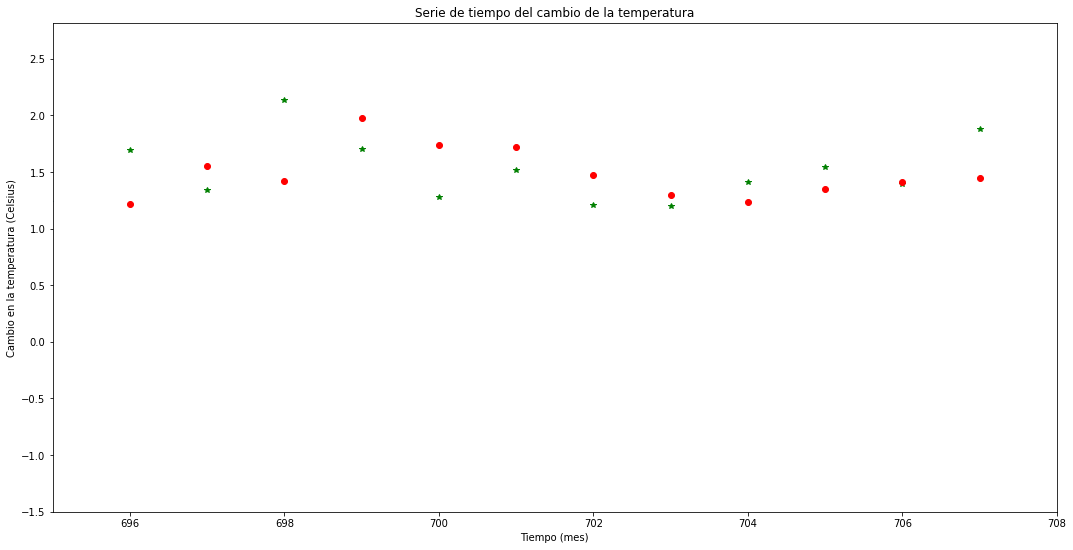

In [679]:
fig= plt.figure(figsize=(18,9))
plt.plot(data[:-n_test])
plt.plot(data[-n_test:],marker = '*',linestyle = ' ',color = 'green')
plt.plot([(len(data) + i - n_test) for i in range(n_test)] , [j[0][0] for j in forecasts], color = 'red', marker = 'o', linestyle = ' ')
plt.xlim((len(data) - n_test - 1,len(data)))
plt.xlabel('Tiempo (mes)')
plt.ylabel('Cambio en la temperatura (Celsius)')
plt.title('Serie de tiempo del cambio de la temperatura')

## Predicciones RNN

In [727]:
scaler, train, test,min,max = prepare_data(data, n_test, n_lag, n_seq)

In [728]:
train_p = np.array(pd.DataFrame(train)[0])
test_p = np.array(pd.DataFrame(test)[0])

In [731]:
trainX = np.reshape(train_p, (train.shape[0], 1, 1))
testX = np.reshape(test_p, (test.shape[0], 1, 1))

predXt = model.predict(trainX)
predXtt = model.predict(testX)
predicted=np.concatenate((predXt,predXtt),axis=0)

predicted =  inverse_transform(pd.DataFrame(predicted),forecasts,scaler,n_test)
predicted = [i[0][0] for i in predicted]

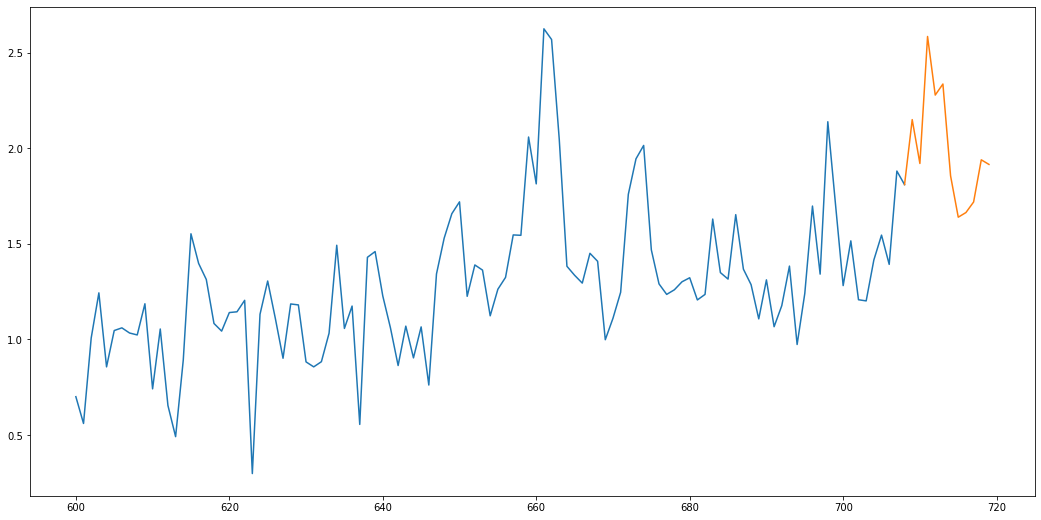

In [782]:
index = data[600:].index.values
index = np.append(index,index[len(index)-1] +1)
fig= plt.figure(figsize=(18,9))
plot_data = [a[0] for a in data[600:].values.tolist()]
plot_data.append(predicted[0])
plot_data = np.array(plot_data)
plt.plot(index,plot_data)
plt.plot([(len(data) + i) for i in range(12)] ,predicted)
plt.show()

# RNN (OECD)

In [795]:
to_analyze = 'OECD'
group = 'Interest Groups'
time_lapse = 'Month'

In [796]:
data=pd.DataFrame(grouped_data[group][time_lapse][to_analyze]).dropna()
#data=(data-data.mean())/data.std()
data

,OECD
0,0.437
1,0.756
2,0.205
3,-0.029
4,-0.290
...,...
703,1.034
704,1.542
705,1.127
706,1.030


In [818]:
n_epochs = 100
n_batch = 1
n_neurons = 64
n_lag = 1
n_seq = 1
n_test = 12
scaler, train, test,min,max = prepare_data(data, n_test, n_lag, n_seq)
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
forecasts = inverse_transform(data, forecasts, scaler, n_test)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(data, actual, scaler, n_test)
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

RMSE: 0.2556150556302454
MSE: 0.06533905666485344


Text(0.5, 1.0, 'Serie de tiempo del cambio de la temperatura')

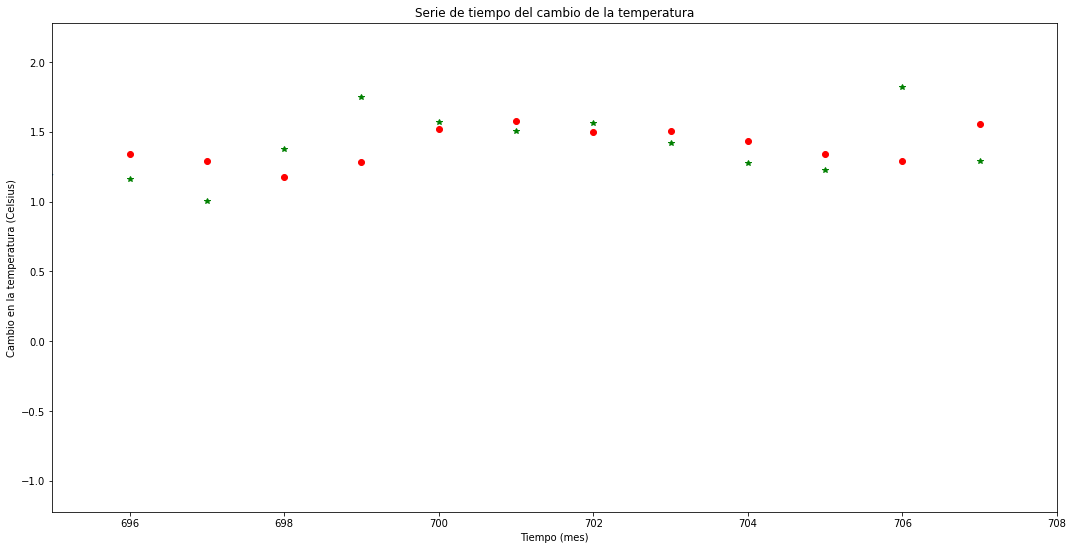

In [819]:
fig= plt.figure(figsize=(18,9))
plt.plot(data[:-n_test])
plt.plot(data[-n_test:],marker = '*',linestyle = ' ',color = 'green')
plt.plot([(len(data) + i - n_test) for i in range(n_test)] , [j[0][0] for j in forecasts], color = 'red', marker = 'o', linestyle = ' ')
plt.xlim((len(data) - n_test - 1,len(data)))
plt.xlabel('Tiempo (mes)')
plt.ylabel('Cambio en la temperatura (Celsius)')
plt.title('Serie de tiempo del cambio de la temperatura')

## Predicciones RNN 

In [820]:
scaler, train, test,min,max = prepare_data(data, n_test, n_lag, n_seq)

In [821]:
train_p = np.array(pd.DataFrame(train)[0])
test_p = np.array(pd.DataFrame(test)[0])

In [822]:
trainX = np.reshape(train_p, (train.shape[0], 1, 1))
testX = np.reshape(test_p, (test.shape[0], 1, 1))

predXt = model.predict(trainX)
predXtt = model.predict(testX)
predicted=np.concatenate((predXt,predXtt),axis=0)

predicted =  inverse_transform(pd.DataFrame(predicted),forecasts,scaler,n_test)
predicted = [i[0][0] for i in predicted]

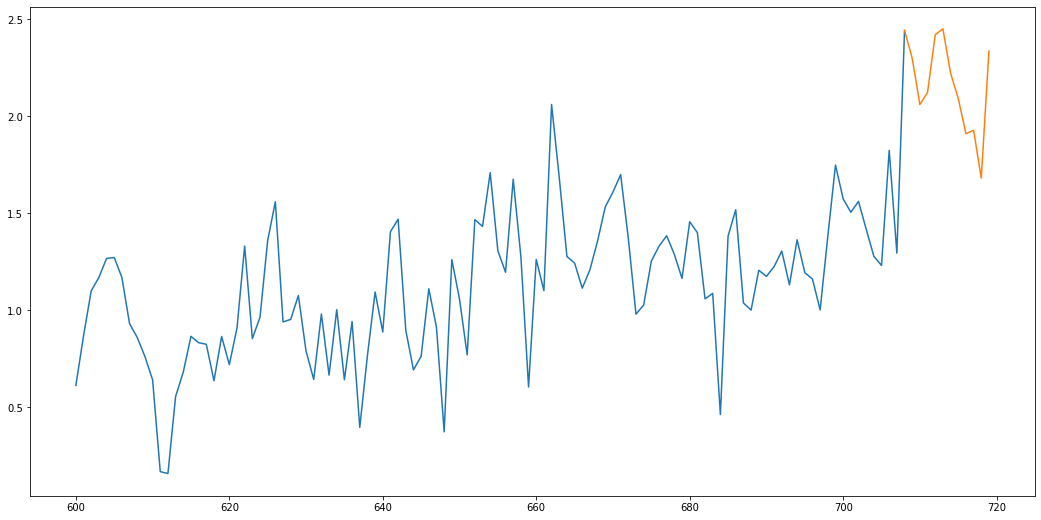

In [823]:
index = data[600:].index.values
index = np.append(index,index[len(index)-1] +1)
fig= plt.figure(figsize=(18,9))
plot_data = [a[0] for a in data[600:].values.tolist()]
plot_data.append(predicted[0])
plot_data = np.array(plot_data)
plt.plot(index,plot_data)
plt.plot([(len(data) + i) for i in range(12)] ,predicted)
plt.show()

# RNN (Underdeveloped countries)

In [810]:
to_analyze = 'Least Developed Countries'
group = 'Interest Groups'
time_lapse = 'Month'

In [811]:
data=pd.DataFrame(grouped_data[group][time_lapse][to_analyze]).dropna()
#data=(data-data.mean())/data.std()
data

,Least Developed Countries
0,0.349
1,-0.897
2,-0.333
3,0.085
4,0.631
...,...
703,1.417
704,1.277
705,1.230
706,1.823


In [812]:
n_epochs = 100
n_batch = 1
n_neurons = 64
n_lag = 1
n_seq = 1
n_test = 12
scaler, train, test,min,max = prepare_data(data, n_test, n_lag, n_seq)
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
forecasts = inverse_transform(data, forecasts, scaler, n_test)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(data, actual, scaler, n_test)
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

RMSE: 0.3023473864625086
MSE: 0.09141394210070952


Text(0.5, 1.0, 'Serie de tiempo del cambio de la temperatura')

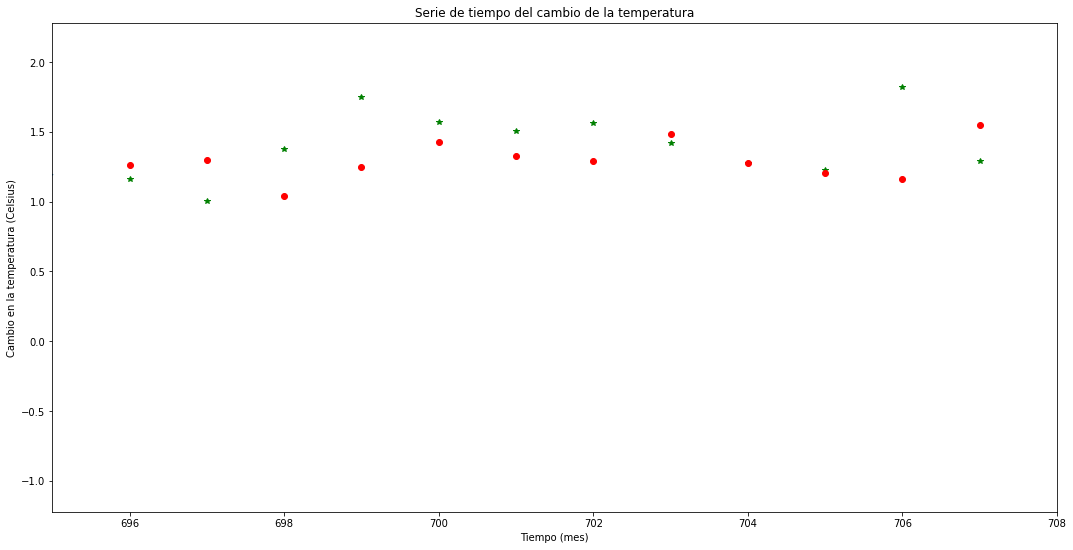

In [813]:
fig= plt.figure(figsize=(18,9))
plt.plot(data[:-n_test])
plt.plot(data[-n_test:],marker = '*',linestyle = ' ',color = 'green')
plt.plot([(len(data) + i - n_test) for i in range(n_test)] , [j[0][0] for j in forecasts], color = 'red', marker = 'o', linestyle = ' ')
plt.xlim((len(data) - n_test - 1,len(data)))
plt.xlabel('Tiempo (mes)')
plt.ylabel('Cambio en la temperatura (Celsius)')
plt.title('Serie de tiempo del cambio de la temperatura')

## Predicciones RNN

In [814]:
scaler, train, test,min,max = prepare_data(data, n_test, n_lag, n_seq)

In [815]:
train_p = np.array(pd.DataFrame(train)[0])
test_p = np.array(pd.DataFrame(test)[0])

In [816]:
trainX = np.reshape(train_p, (train.shape[0], 1, 1))
testX = np.reshape(test_p, (test.shape[0], 1, 1))

predXt = model.predict(trainX)
predXtt = model.predict(testX)
predicted=np.concatenate((predXt,predXtt),axis=0)

predicted =  inverse_transform(pd.DataFrame(predicted),forecasts,scaler,n_test)
predicted = [i[0][0] for i in predicted]

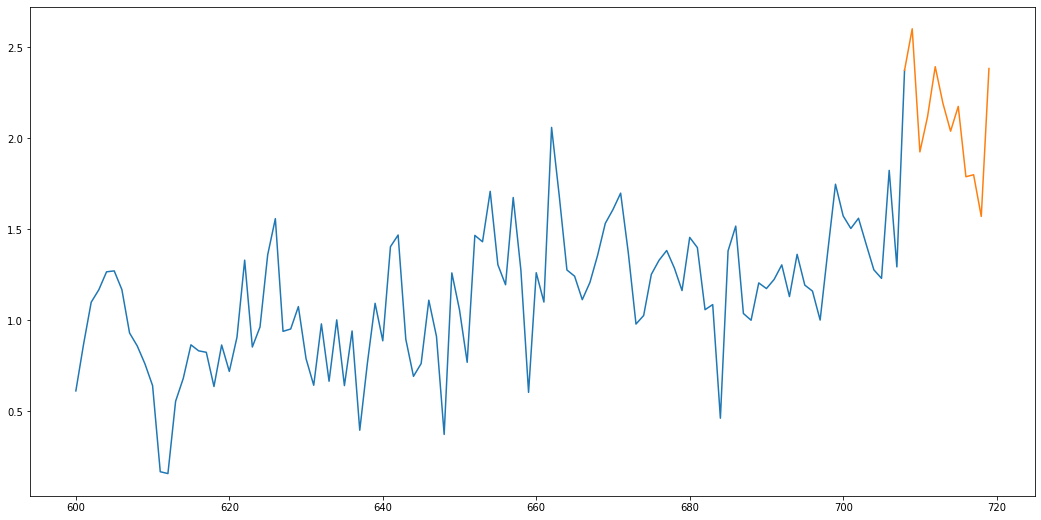

In [817]:
index = data[600:].index.values
index = np.append(index,index[len(index)-1] +1)
fig= plt.figure(figsize=(18,9))
plot_data = [a[0] for a in data[600:].values.tolist()]
plot_data.append(predicted[0])
plot_data = np.array(plot_data)
plt.plot(index,plot_data)
plt.plot([(len(data) + i) for i in range(12)] ,predicted)
plt.show()

# RNN (Continents)

## America

RMSE: 0.5076409505804731
MSE: 0.25769933470624634


Text(0.5, 1.0, 'Serie de tiempo del cambio de la temperatura')

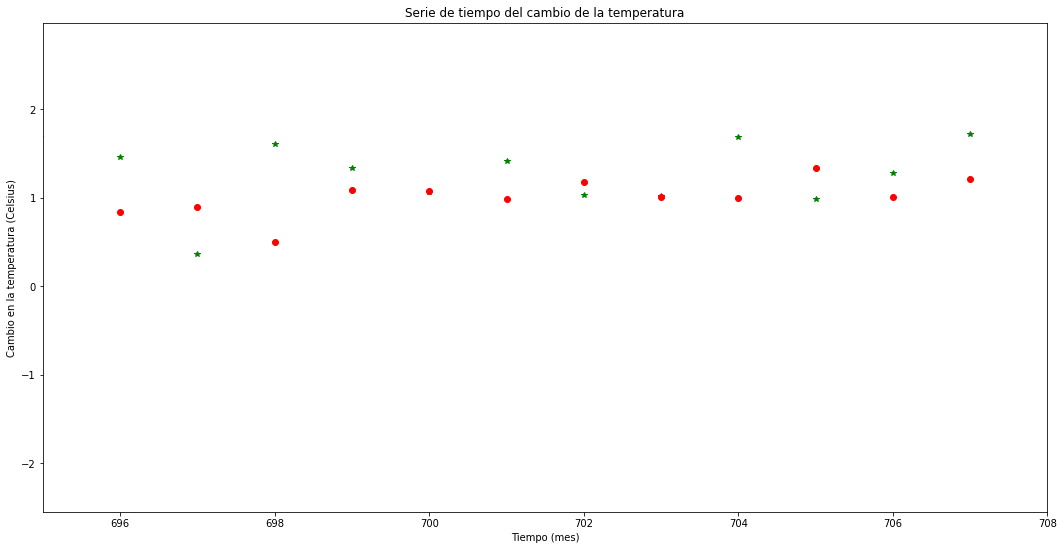

In [861]:
to_analyze = 'Americas'
group = 'Continents'
time_lapse = 'Month'
data=pd.DataFrame(grouped_data[group][time_lapse][to_analyze]).dropna()
#data=(data-data.mean())/data.std()
data

n_epochs = 100
n_batch = 1
n_neurons = 64
n_lag = 1
n_seq = 1
n_test = 12
scaler, train, test,min,max = prepare_data(data, n_test, n_lag, n_seq)
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
forecasts = inverse_transform(data, forecasts, scaler, n_test)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(data, actual, scaler, n_test)
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

fig= plt.figure(figsize=(18,9))
plt.plot(data[:-n_test])
plt.plot(data[-n_test:],marker = '*',linestyle = ' ',color = 'green')
plt.plot([(len(data) + i - n_test) for i in range(n_test)] , [j[0][0] for j in forecasts], color = 'red', marker = 'o', linestyle = ' ')
plt.xlim((len(data) - n_test - 1,len(data)))
plt.xlabel('Tiempo (mes)')
plt.ylabel('Cambio en la temperatura (Celsius)')
plt.title('Serie de tiempo del cambio de la temperatura')

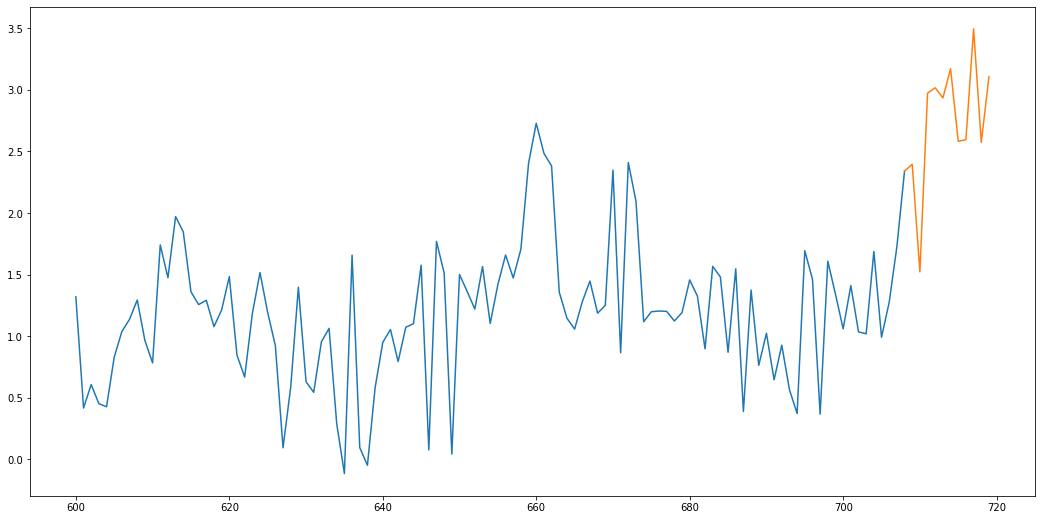

In [862]:
scaler, train, test,min,max = prepare_data(data, n_test, n_lag, n_seq)
train_p = np.array(pd.DataFrame(train)[0])
test_p = np.array(pd.DataFrame(test)[0])

trainX = np.reshape(train_p, (train.shape[0], 1, 1))
testX = np.reshape(test_p, (test.shape[0], 1, 1))

predXt = model.predict(trainX)
predXtt = model.predict(testX)
predicted=np.concatenate((predXt,predXtt),axis=0)

predicted =  inverse_transform(pd.DataFrame(predicted),forecasts,scaler,n_test)
predicted = [i[0][0] for i in predicted]

index = data[600:].index.values
index = np.append(index,index[len(index)-1] +1)
fig= plt.figure(figsize=(18,9))
plot_data = [a[0] for a in data[600:].values.tolist()]
plot_data.append(predicted[0])
plot_data = np.array(plot_data)
plt.plot(index,plot_data)
plt.plot([(len(data) + i) for i in range(12)] ,predicted)
plt.show()

## Europe

RMSE: 1.538565229841738
MSE: 2.36718296647796


Text(0.5, 1.0, 'Serie de tiempo del cambio de la temperatura')

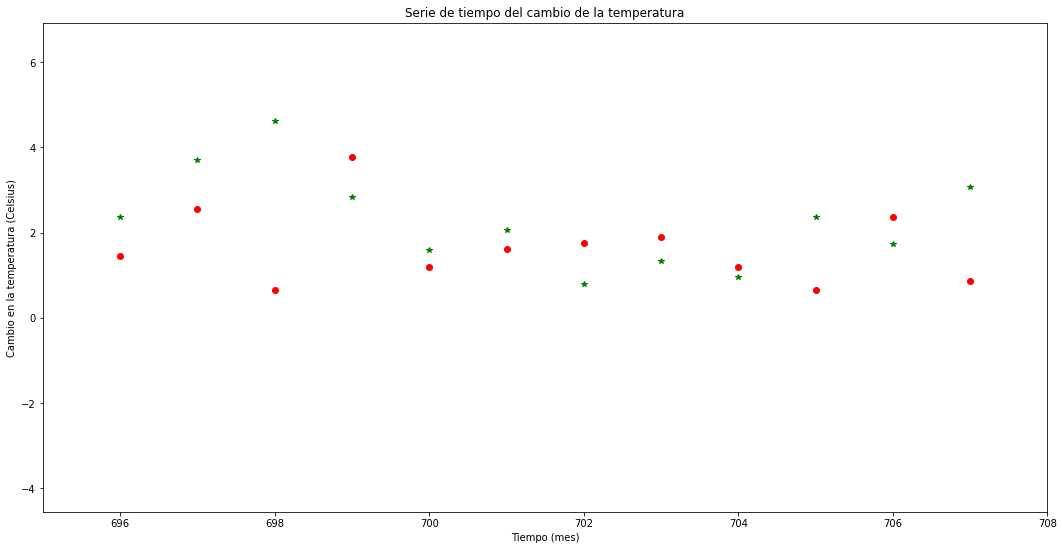

In [863]:
to_analyze = 'Europe'
group = 'Continents'
time_lapse = 'Month'
data=pd.DataFrame(grouped_data[group][time_lapse][to_analyze]).dropna()
#data=(data-data.mean())/data.std()
data

n_epochs = 500
n_batch = 1
n_neurons = 128
n_lag = 1
n_seq = 1
n_test = 12
scaler, train, test,min,max = prepare_data(data, n_test, n_lag, n_seq)
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
forecasts = inverse_transform(data, forecasts, scaler, n_test)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(data, actual, scaler, n_test)
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

fig= plt.figure(figsize=(18,9))
plt.plot(data[:-n_test])
plt.plot(data[-n_test:],marker = '*',linestyle = ' ',color = 'green')
plt.plot([(len(data) + i - n_test) for i in range(n_test)] , [j[0][0] for j in forecasts], color = 'red', marker = 'o', linestyle = ' ')
plt.xlim((len(data) - n_test - 1,len(data)))
plt.xlabel('Tiempo (mes)')
plt.ylabel('Cambio en la temperatura (Celsius)')
plt.title('Serie de tiempo del cambio de la temperatura')

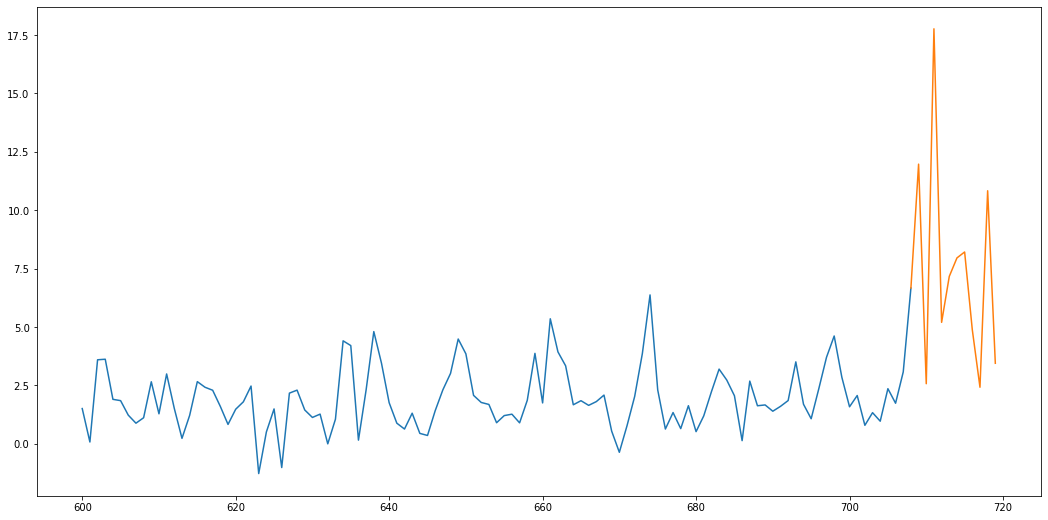

In [864]:
scaler, train, test,min,max = prepare_data(data, n_test, n_lag, n_seq)
train_p = np.array(pd.DataFrame(train)[0])
test_p = np.array(pd.DataFrame(test)[0])

trainX = np.reshape(train_p, (train.shape[0], 1, 1))
testX = np.reshape(test_p, (test.shape[0], 1, 1))

predXt = model.predict(trainX)
predXtt = model.predict(testX)
predicted=np.concatenate((predXt,predXtt),axis=0)

predicted =  inverse_transform(pd.DataFrame(predicted),forecasts,scaler,n_test)
predicted = [i[0][0] for i in predicted]

index = data[600:].index.values
index = np.append(index,index[len(index)-1] +1)
fig= plt.figure(figsize=(18,9))
plot_data = [a[0] for a in data[600:].values.tolist()]
plot_data.append(predicted[0])
plot_data = np.array(plot_data)
plt.plot(index,plot_data)
plt.plot([(len(data) + i) for i in range(12)] ,predicted)
plt.show()

## Oceania

RMSE: 0.7775447763442617
MSE: 0.6045758792202479


Text(0.5, 1.0, 'Serie de tiempo del cambio de la temperatura')

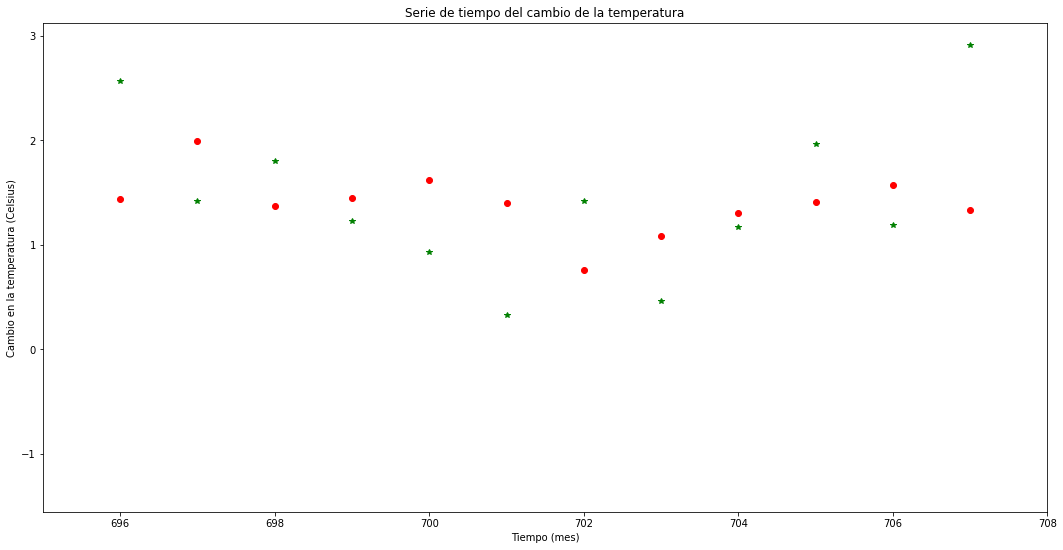

In [858]:
to_analyze = 'Oceania'
group = 'Continents'
time_lapse = 'Month'
data=pd.DataFrame(grouped_data[group][time_lapse][to_analyze]).dropna()
#data=(data-data.mean())/data.std()
data

n_epochs = 100
n_batch = 1
n_neurons = 64
n_lag = 1
n_seq = 1
n_test = 12
scaler, train, test,min,max = prepare_data(data, n_test, n_lag, n_seq)
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
forecasts = inverse_transform(data, forecasts, scaler, n_test)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(data, actual, scaler, n_test)
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

fig= plt.figure(figsize=(18,9))
plt.plot(data[:-n_test])
plt.plot(data[-n_test:],marker = '*',linestyle = ' ',color = 'green')
plt.plot([(len(data) + i - n_test) for i in range(n_test)] , [j[0][0] for j in forecasts], color = 'red', marker = 'o', linestyle = ' ')
plt.xlim((len(data) - n_test - 1,len(data)))
plt.xlabel('Tiempo (mes)')
plt.ylabel('Cambio en la temperatura (Celsius)')
plt.title('Serie de tiempo del cambio de la temperatura')

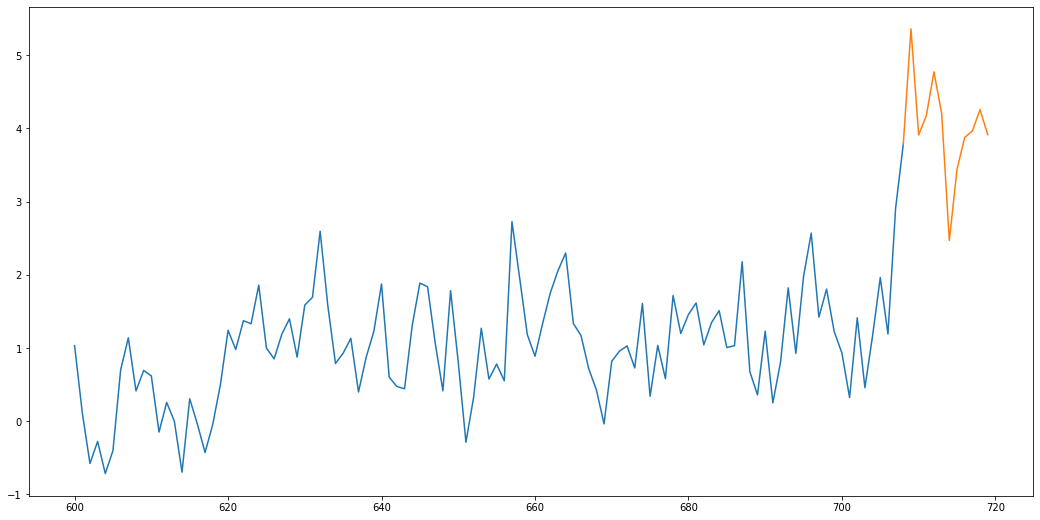

In [859]:
scaler, train, test,min,max = prepare_data(data, n_test, n_lag, n_seq)
train_p = np.array(pd.DataFrame(train)[0])
test_p = np.array(pd.DataFrame(test)[0])

trainX = np.reshape(train_p, (train.shape[0], 1, 1))
testX = np.reshape(test_p, (test.shape[0], 1, 1))

predXt = model.predict(trainX)
predXtt = model.predict(testX)
predicted=np.concatenate((predXt,predXtt),axis=0)

predicted =  inverse_transform(pd.DataFrame(predicted),forecasts,scaler,n_test)
predicted = [i[0][0] for i in predicted]

index = data[600:].index.values
index = np.append(index,index[len(index)-1] +1)
fig= plt.figure(figsize=(18,9))
plot_data = [a[0] for a in data[600:].values.tolist()]
plot_data.append(predicted[0])
plot_data = np.array(plot_data)
plt.plot(index,plot_data)
plt.plot([(len(data) + i) for i in range(12)] ,predicted)
plt.show()

## Africa

RMSE: 0.2548482087939283
MSE: 0.06494760952547367


Text(0.5, 1.0, 'Serie de tiempo del cambio de la temperatura')

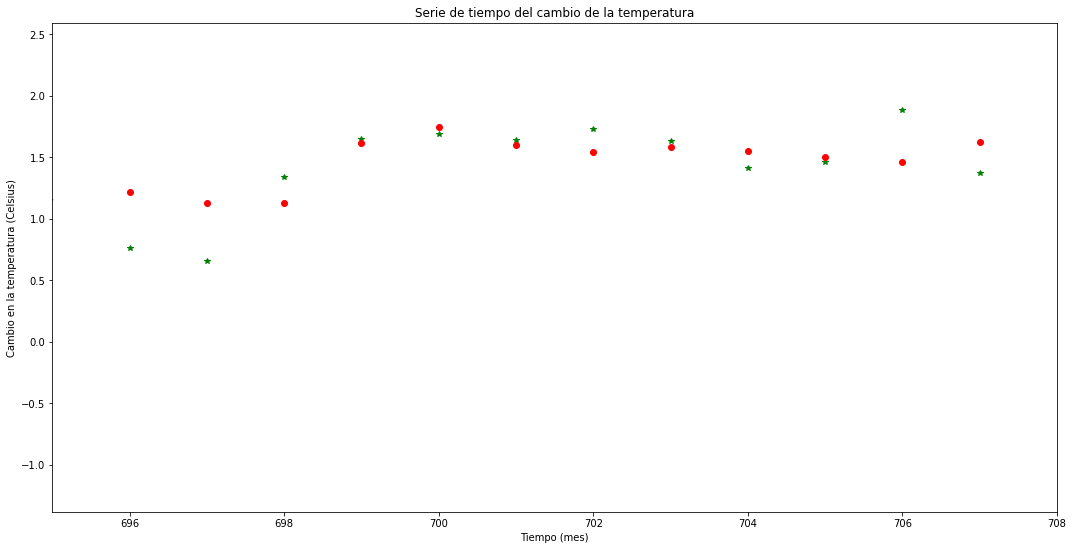

In [841]:
to_analyze = 'Africa'
group = 'Continents'
time_lapse = 'Month'
data=pd.DataFrame(grouped_data[group][time_lapse][to_analyze]).dropna()
#data=(data-data.mean())/data.std()
data

n_epochs = 100
n_batch = 1
n_neurons = 64
n_lag = 1
n_seq = 1
n_test = 12
scaler, train, test,min,max = prepare_data(data, n_test, n_lag, n_seq)
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
forecasts = inverse_transform(data, forecasts, scaler, n_test)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(data, actual, scaler, n_test)
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

fig= plt.figure(figsize=(18,9))
plt.plot(data[:-n_test])
plt.plot(data[-n_test:],marker = '*',linestyle = ' ',color = 'green')
plt.plot([(len(data) + i - n_test) for i in range(n_test)] , [j[0][0] for j in forecasts], color = 'red', marker = 'o', linestyle = ' ')
plt.xlim((len(data) - n_test - 1,len(data)))
plt.xlabel('Tiempo (mes)')
plt.ylabel('Cambio en la temperatura (Celsius)')
plt.title('Serie de tiempo del cambio de la temperatura')

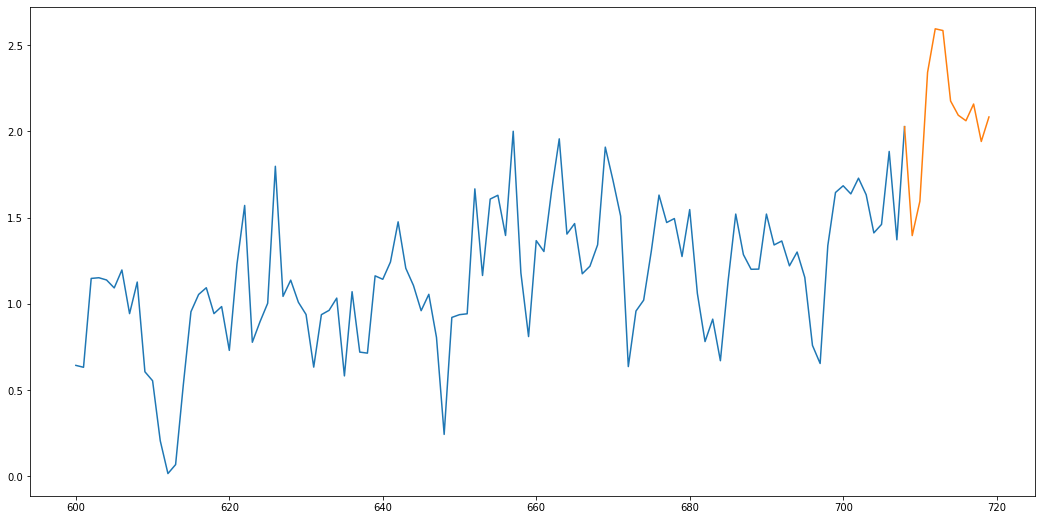

In [842]:
scaler, train, test,min,max = prepare_data(data, n_test, n_lag, n_seq)
train_p = np.array(pd.DataFrame(train)[0])
test_p = np.array(pd.DataFrame(test)[0])

trainX = np.reshape(train_p, (train.shape[0], 1, 1))
testX = np.reshape(test_p, (test.shape[0], 1, 1))

predXt = model.predict(trainX)
predXtt = model.predict(testX)
predicted=np.concatenate((predXt,predXtt),axis=0)

predicted =  inverse_transform(pd.DataFrame(predicted),forecasts,scaler,n_test)
predicted = [i[0][0] for i in predicted]

index = data[600:].index.values
index = np.append(index,index[len(index)-1] +1)
fig= plt.figure(figsize=(18,9))
plot_data = [a[0] for a in data[600:].values.tolist()]
plot_data.append(predicted[0])
plot_data = np.array(plot_data)
plt.plot(index,plot_data)
plt.plot([(len(data) + i) for i in range(12)] ,predicted)
plt.show()

## Asia

RMSE: 0.4942325502755741
MSE: 0.2442658137518979


Text(0.5, 1.0, 'Serie de tiempo del cambio de la temperatura')

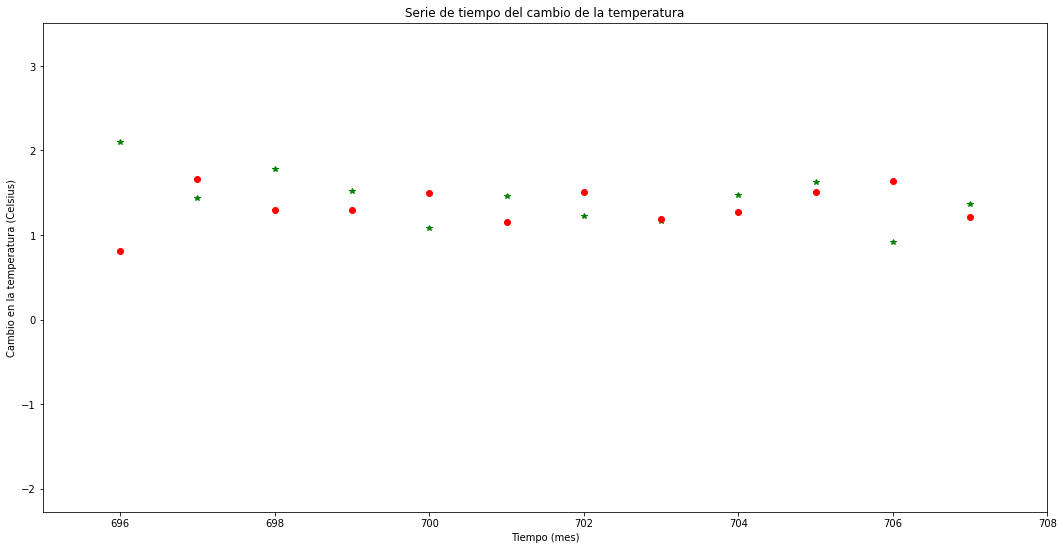

In [856]:
to_analyze = 'Asia'
group = 'Continents'
time_lapse = 'Month'
data=pd.DataFrame(grouped_data[group][time_lapse][to_analyze]).dropna()
#data=(data-data.mean())/data.std()
data

n_epochs = 100
n_batch = 1
n_neurons = 128
n_lag = 1
n_seq = 1
n_test = 12
scaler, train, test,min,max = prepare_data(data, n_test, n_lag, n_seq)
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
forecasts = inverse_transform(data, forecasts, scaler, n_test)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(data, actual, scaler, n_test)
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

fig= plt.figure(figsize=(18,9))
plt.plot(data[:-n_test])
plt.plot(data[-n_test:],marker = '*',linestyle = ' ',color = 'green')
plt.plot([(len(data) + i - n_test) for i in range(n_test)] , [j[0][0] for j in forecasts], color = 'red', marker = 'o', linestyle = ' ')
plt.xlim((len(data) - n_test - 1,len(data)))
plt.xlabel('Tiempo (mes)')
plt.ylabel('Cambio en la temperatura (Celsius)')
plt.title('Serie de tiempo del cambio de la temperatura')

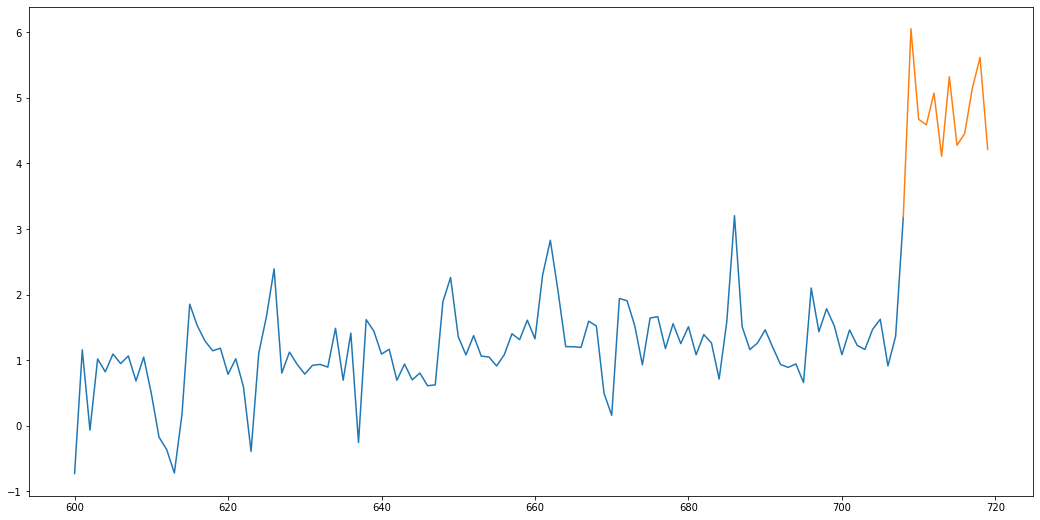

In [857]:
scaler, train, test,min,max = prepare_data(data, n_test, n_lag, n_seq)
train_p = np.array(pd.DataFrame(train)[0])
test_p = np.array(pd.DataFrame(test)[0])

trainX = np.reshape(train_p, (train.shape[0], 1, 1))
testX = np.reshape(test_p, (test.shape[0], 1, 1))

predXt = model.predict(trainX)
predXtt = model.predict(testX)
predicted=np.concatenate((predXt,predXtt),axis=0)

predicted =  inverse_transform(pd.DataFrame(predicted),forecasts,scaler,n_test)
predicted = [i[0][0] for i in predicted]

index = data[600:].index.values
index = np.append(index,index[len(index)-1] +1)
fig= plt.figure(figsize=(18,9))
plot_data = [a[0] for a in data[600:].values.tolist()]
plot_data.append(predicted[0])
plot_data = np.array(plot_data)
plt.plot(index,plot_data)
plt.plot([(len(data) + i) for i in range(12)] ,predicted)
plt.show()